# 공통파일


In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path_son = 'datathon_energy/'

train = pd.read_csv(file_path_son+'train.csv', encoding='cp949')
test = pd.read_csv(file_path_son+'test.csv', encoding='cp949')

#train = pd.read_csv('~/_Python/Exploration/data/energy/train.csv', encoding = "cp949")
#test = pd.read_csv('~/_Python/Exploration/data/energy/test.csv', encoding = "cp949")
train.columns = ['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']
train['date']= pd.to_datetime(train['date'])


# 1. 데이타 분석

In [4]:
train.shape

(122400, 10)

In [5]:
train.head()

,num,date,use_electric,temperature,wind_speed,humidity,precipitation,sunshine,operation,solar_power
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [6]:
train.columns

Index(['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity',
       'precipitation', 'sunshine', 'operation', 'solar_power'],
      dtype='object')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122400 non-null  int64         
 1   date           122400 non-null  datetime64[ns]
 2   use_electric   122400 non-null  float64       
 3   temperature    122400 non-null  float64       
 4   wind_speed     122400 non-null  float64       
 5   humidity       122400 non-null  float64       
 6   precipitation  122400 non-null  float64       
 7   sunshine       122400 non-null  float64       
 8   operation      122400 non-null  float64       
 9   solar_power    122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [8]:
train.describe()

,num,use_electric,temperature,wind_speed,humidity,precipitation,sunshine,operation,solar_power
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


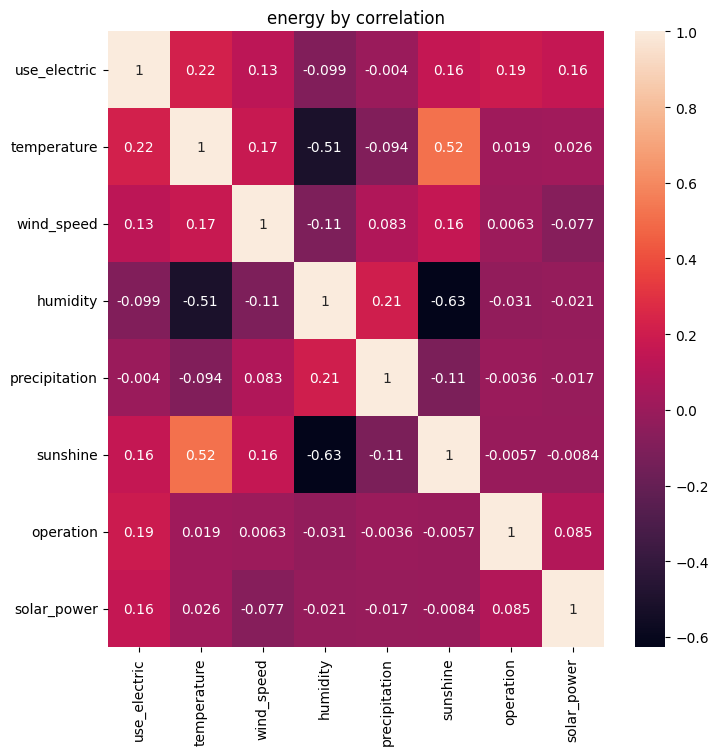

In [10]:
corr_df= train[['use_electric', 'date', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']]

# 한글 폰트 사용을 위해서 세팅
'''
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
'''

plt.figure(figsize=(8,8))

sns.heatmap(data=corr_df.corr(), annot=True)
plt.title('energy by correlation')
plt.show()

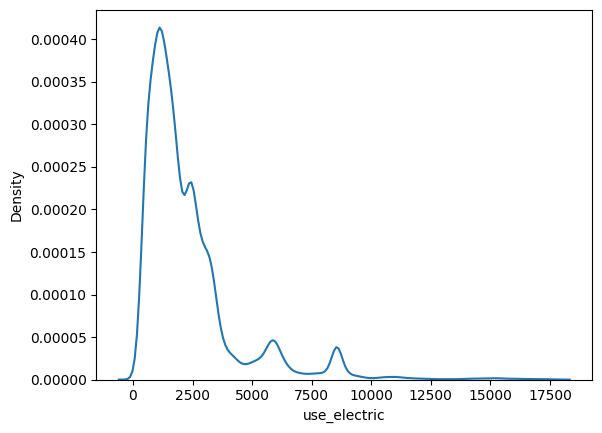

In [14]:
sns.kdeplot(data=train['use_electric'])
plt.show()

In [15]:
train['use_electric'].skew()  #왜도 : 분포가 대칭을 벗어나 치우친 정도

2.569979214229397

In [16]:
train['use_electric'].kurt()  # 첨도 : 뽀족한 정도

8.998589167827355

## feature 별 전력사용량과의 관계

In [20]:
# CATE_COLS = ['num', "mgrp", 'holiday', 'dow', 'cluster', 'hot', 'nelec_cool_flag', 'solar_flag']
# for col in CATE_COLS:
#     df[col] = df[col].astype(str).astype('category')





In [24]:
train.head()

,num,date,use_electric,temperature,wind_speed,humidity,precipitation,sunshine,operation,solar_power
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


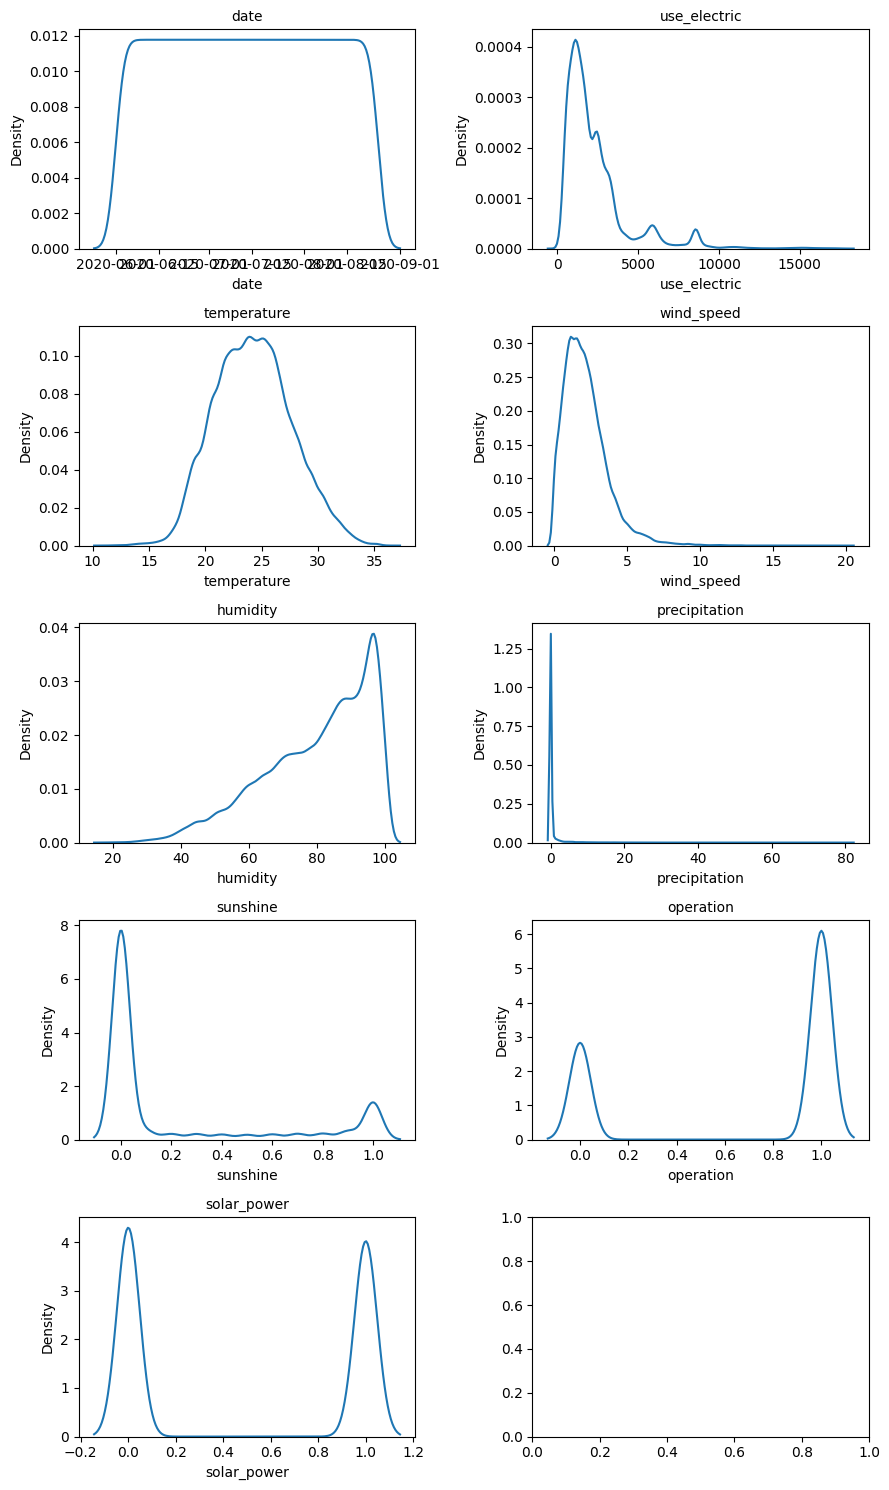

In [17]:
skew_columns = ['date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']

fig, ax = plt.subplots(5, 2, figsize=(9, 15), tight_layout=True)

count = 0
for row in range(5):
    for col in range(2):
        if count == 9:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col] )
        ax[row][col].set_title(skew_columns[count], fontsize=10)
        count += 1

In [ ]:
## 개별 컬럼 분석

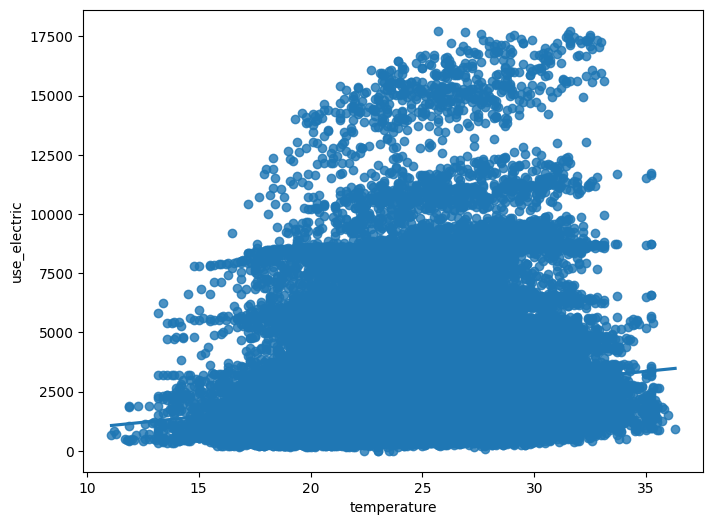

In [19]:
#'date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power'

data = pd.concat([train['use_electric'], train['temperature']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='temperature', y="use_electric", data=data)

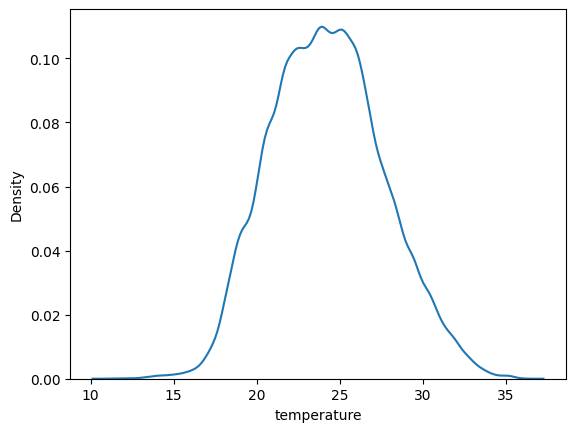

In [20]:
kde = sns.kdeplot(train['temperature'])

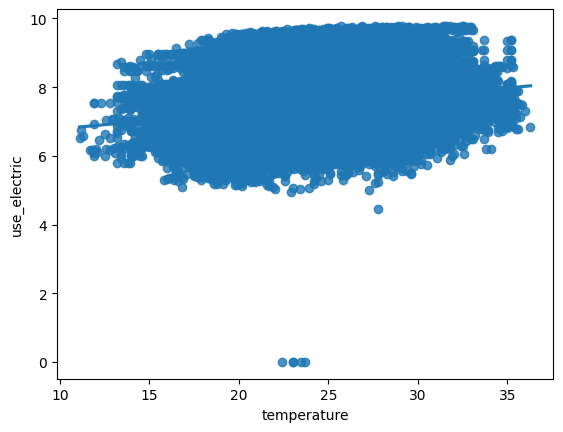

In [22]:
x,y = train['temperature'], np.log1p(train['use_electric'])   # 시계열 데이터라서 상관도로 보기에는 힘듬.

fig = sns.regplot(x=x,y=y)

In [11]:
# 시간 변수

date = train['date']
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear # 1년

In [31]:
train['week'].unique()

array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], dtype=int64)

In [13]:
# 공휴일 변수 추가

train['holiday'] = train.apply(lambda x : 0 if['day']<5 else 1, axis=1)
train.loc[('2020-08-17'<=train.date_time) &(train.date_time<'2020-08-18'),'holiday']=1

array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], dtype=int64)

In [15]:
# 시간을 sin, cos 함수로

train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

In [17]:
# THI(temperature-humidity index) : 불쾌지수

train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

In [19]:
# CDH(Cooling Degree Hour) : 냉방 도일

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

In [27]:
# 체감 온도

train['body_temperature'] = 13.12 + 0.6215*train['temperature'] - 11.37*(train['wind_speed']*3.6)**0.16 + 0.3965*(train['wind_speed']*3.6)**0.16*train['temperature']

In [26]:
# 화씨로 변형

train['temperature_F'] = (train['temperature'] * 9/5) + 32 

# 열지수

T = train['temperature_F']
RH = train['humidity']
train['heat_index'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
train['heat_index'] = (train['heat_index']-32) * 5/9
train.loc[train['heat_index']<32, 'heat_index'] = 0
train.loc[(train['heat_index']>=32) & (train['heat_index']<41), 'heat_index'] = 1
train.loc[(train['heat_index']>=41) & (train['heat_index']<54), 'heat_index'] = 2
train.loc[(train['heat_index']>=54) & (train['heat_index']<66), 'heat_index'] = 3
train.loc[train['heat_index']>=66, 'heat_index'] = 4

In [33]:
train.columns

Index(['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity',
       'precipitation', 'sunshine', 'operation', 'solar_power', 'hour', 'day',
       'month', 'week', 'sin_time', 'cos_time', 'THI', 'CDH', 'temperature_F',
       'heat_index', 'body_temperature'],
      dtype='object')

In [34]:
train.corr()

,num,use_electric,temperature,wind_speed,humidity,precipitation,sunshine,operation,solar_power,hour,day,month,week,sin_time,cos_time,THI,CDH,temperature_F,heat_index,body_temperature
num,1.000000e+00,-0.004309,0.000363,-0.052184,0.005379,-0.004673,-0.013685,6.103135e-02,9.918068e-02,-1.864340e-15,-5.496906e-15,-1.903384e-14,-2.176205e-14,5.350831e-19,8.547108e-18,0.012133,0.000415,0.000363,-0.022479,0.008422
use_electric,-4.309068e-03,1.000000,0.219134,0.128049,-0.098846,-0.004043,0.158124,1.899892e-01,1.556097e-01,1.523063e-01,-6.750206e-02,6.182402e-02,7.275044e-02,-1.611600e-01,-2.613590e-01,0.128133,0.063445,0.219134,0.128709,0.204165
temperature,3.631250e-04,0.219134,1.000000,0.167455,-0.509105,-0.093788,0.515657,1.906651e-02,2.586485e-02,2.997718e-01,3.893405e-02,3.878394e-01,3.970669e-01,-3.898569e-01,-3.676551e-01,0.560367,0.667055,1.000000,0.552098,0.985736
wind_speed,-5.218413e-02,0.128049,0.167455,1.000000,-0.110439,0.083433,0.156381,6.274912e-03,-7.655996e-02,1.540747e-01,-1.574157e-02,4.934480e-02,3.628025e-02,-2.070265e-01,-1.857481e-01,0.065033,0.031380,0.167455,0.114513,0.074512
humidity,5.378530e-03,-0.098846,-0.509105,-0.110439,1.000000,0.208862,-0.627597,-3.140481e-02,-2.065729e-02,-2.603125e-01,1.437564e-02,3.190720e-01,3.395022e-01,3.408332e-01,3.178028e-01,0.325783,-0.143657,-0.509105,-0.203578,-0.492487
precipitation,-4.673261e-03,-0.004043,-0.093788,0.083433,0.208862,1.000000,-0.112646,-3.559549e-03,-1.668520e-02,-2.218069e-02,-1.688954e-02,8.396050e-02,8.642093e-02,3.620632e-02,-5.170381e-03,0.155578,-0.039229,-0.093788,-0.061485,-0.107031
sunshine,-1.368529e-02,0.158124,0.515657,0.156381,-0.627597,-0.112646,1.000000,-5.694932e-03,-8.412045e-03,1.617544e-01,5.471815e-03,-1.278696e-01,-1.343174e-01,-2.021759e-01,-4.925586e-01,0.006842,0.007814,0.515657,0.314021,0.506081
operation,6.103135e-02,0.189989,0.019067,0.006275,-0.031405,-0.003560,-0.005695,1.000000e+00,8.484178e-02,6.172320e-16,3.985792e-16,2.163714e-16,-3.890250e-15,-6.432029e-19,2.599008e-18,-0.009674,0.022738,0.019067,0.004559,0.014863
solar_power,9.918068e-02,0.155610,0.025865,-0.076560,-0.020657,-0.016685,-0.008412,8.484178e-02,1.000000e+00,1.085166e-15,-1.568616e-15,4.671556e-15,-2.036105e-15,-1.750009e-18,2.416771e-18,0.013759,0.030872,0.025865,0.021518,0.036508
hour,-1.864340e-15,0.152306,0.299772,0.154075,-0.260312,-0.022181,0.161754,6.172320e-16,1.085166e-15,1.000000e+00,4.221531e-18,-8.195051e-17,-8.488862e-17,-7.759122e-01,-1.021508e-01,0.058027,0.222830,0.299772,0.143056,0.274578


# 2.모델링 전략 수립

# 3. 전처리

# 4. Normalization

# 5.모델링

# 6.하이퍼 파라미터 

# 7.훈련 및 예측 Blending

# 8. 파일 출력 및 제출

# 9.회고